In [ ]:
# MINI-PROJECT: LANE DETECTION

"""
Input for Program: Image of a road with clearly labelled lanes
Expected Output: Lanes highlighted with white superimposed on the original image
Read the input images from the folder 'LD_test_imgs' and show the output images in the notebook.
You may check the following functions out:
1. cv2.inRange()
2. cv2.bitwise_or() and cv2.bitwise_and
3. cv2.fillPoly()
4. cv2.line()
5. cv2.addWeighted()
In addition, you may consider the structure of the program (functions that one may define) we discussed
in the previous cell.

Fill in your code in place of 'pass'.
"""

"\nInput for Program: Image of a road with clearly labelled lanes\nExpected Output: Lanes highlighted with white superimposed on the original image\nRead the input images from the folder 'LD_test_imgs' and show the output images in the notebook.\nYou may check the following functions out:\n1. cv2.inRange()\n2. cv2.bitwise_or() and cv2.bitwise_and\n3. cv2.fillPoly()\n4. cv2.line()\n5. cv2.addWeighted()\nIn addition, you may consider the structure of the program (functions that one may define) we discussed \nin the previous cell.\n\nFill in your code in place of 'pass'.\n"

In [ ]:

def img2edge(img):
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv_image  = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    """
    Define ranges for 'yellow', pixels within this range will be picked
    """
    lower_yellow = np.array([20,100,100])
    upper_yellow = np.array([30, 255, 255])

    """
    cv2.inRange(): Picks pixels from the image that are in the specified range
    """
    mask_y = cv2.inRange(hsv_image,lower_yellow,upper_yellow)
    mask_w = cv2.inRange(gray_image, 200, 255)

    """
    Compute Bitwise OR, combining both the white and yellow pixels
    """
    mask_yw = cv2.bitwise_or(mask_y,mask_w)

    """
    Compute Bitwise AND of mask_yw with gray_img, pixels that were yellow or
    white will have the same intensity as the original grayscale image, the
    other pixels will be removed.
    """
    mask_yw_image = cv2.bitwise_and(gray_image,mask_yw)

    img_blur = cv2.GaussianBlur(mask_yw_image, (5, 5), 0)
    img_canny = cv2.Canny(img_blur, 25,150 )

    return img_canny

def roi_select(img, canny):
    """
    Define the vertices of the region of interest
    """
    h,w = img.shape[:2]
    lower_left = np.array([0,h])
    lower_right = np.array([w,h])
    top_left = np.array([2*w/5,2*h/6])
    top_right = np.array([(3*w/5),2*h/6])
    vertices = [np.array([lower_left,top_left,top_right,lower_right],dtype=np.int32)]

    mask = np.zeros_like(canny)                     #creates a numpy array of the same dimensions as img
    fill_color = 255                                #parameter for cv2.fillPoly function
    cv2.fillPoly(mask, vertices, fill_color)        #pixels within 'vertices' in 'mask' will be made WHITE while all other pixels will be BLACK

    return cv2.bitwise_and(canny, mask)


def add_weighted(img, line_img):

    return cv2.addWeighted(img, 0.8, line_img, 1, 0)

function to detect lanes without averaging the lines

In [ ]:



def draw_lines(canny_roi, rho_acc, theta_acc, thresh, minLL, maxLG):
    """
    Inputs - canny_roi
    Parameters of HoughLinesP() are passed in as parameters to draw_lines()
    Output - line_img (image of lines against a black background)

    Perform Probabilistic Hough Transform on it, draw lines on a blank image using the values
    returned by HoughLinesP() and the openCV function cv2.line().
    """
    lines = cv2.HoughLinesP(canny_roi, rho=rho_acc, theta=theta_acc, threshold=thresh, minLineLength=minLL, maxLineGap=maxLG)
    line_img = np.zeros_like(canny_roi)
    if lines is not None:
      for line in lines:
          x1, y1, x2, y2 = line[0]
          #polyfit finds the slope and intercept
          parameters = np.polyfit((x1, x2), (y1, y2), 1)
          slope = abs(parameters[0])
          #if block to discard horizontal lines that get detected
          if slope>0.4 :
              cv2.line(line_img, (x1, y1), (x2, y2), (255, 0, 0), 5)


    line_img = cv2.cvtColor(line_img, cv2.COLOR_GRAY2BGR)

    return line_img


def lanes(img):


    edge_img = img2edge(img)


    roi_img = roi_select(img, edge_img)


    hough_img = draw_lines(roi_img, 3, np.pi/180, 60, 40, 5)    #Change the parameters thresh, minLL, maxLG to get more accurate lines

    lane_img = add_weighted(img,hough_img)
    return lane_img

function to detect lanes after averaging lines  [method 2]

In [ ]:
def create_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1 * (0.63))
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)

        # It will fit the polynomial and the intercept and slope
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        #if else block to determine left and right lines of lane
        if abs(slope)>0.5:
            if slope < 0:
                left_fit.append((slope, intercept))
            else:
                right_fit.append((slope, intercept))

    left_fit_average = np.average(left_fit, axis = 0)
    right_fit_average = np.average(right_fit, axis = 0)
    left_line = create_coordinates(image, left_fit_average)
    right_line = create_coordinates(image, right_fit_average)
    return np.array([left_line, right_line])


def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            cv2.line(line_image, (x1, y1), (x2, y2), (255,255, 255), 5)
    return line_image

def lanes1(img):


    edge_img = img2edge(img)
    roi_img = roi_select(img, edge_img)
    lines = cv2.HoughLinesP(roi_img, 2, np.pi / 180, 60,
                            np.array([]), minLineLength = 40,
                            maxLineGap = 5)

    averaged_lines = average_slope_intercept(img, lines)
    line_image = display_lines(img, averaged_lines)
    lane_img = add_weighted(img,line_image)
    return lane_img

In [ ]:
img1 = cv2.imread('LD_test_imgs/test_img01.jpeg',1)
img2 = cv2.imread('LD_test_imgs/test_img02.jpeg',1)
img3 = cv2.imread('LD_test_imgs/test_img03.jpeg',1)

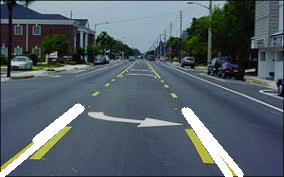



using method 2




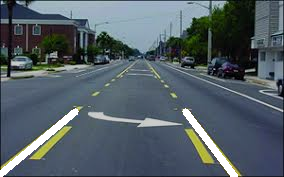

In [ ]:
cv2_imshow(lanes(img1))
print("\n\nusing method 2\n\n")
cv2_imshow(lanes1(img1))

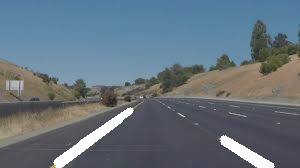



using method 2




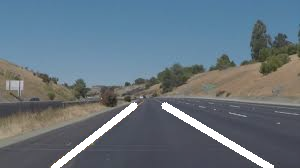

In [ ]:
cv2_imshow(lanes(img2))
print("\n\nusing method 2\n\n")
cv2_imshow(lanes1(img2))

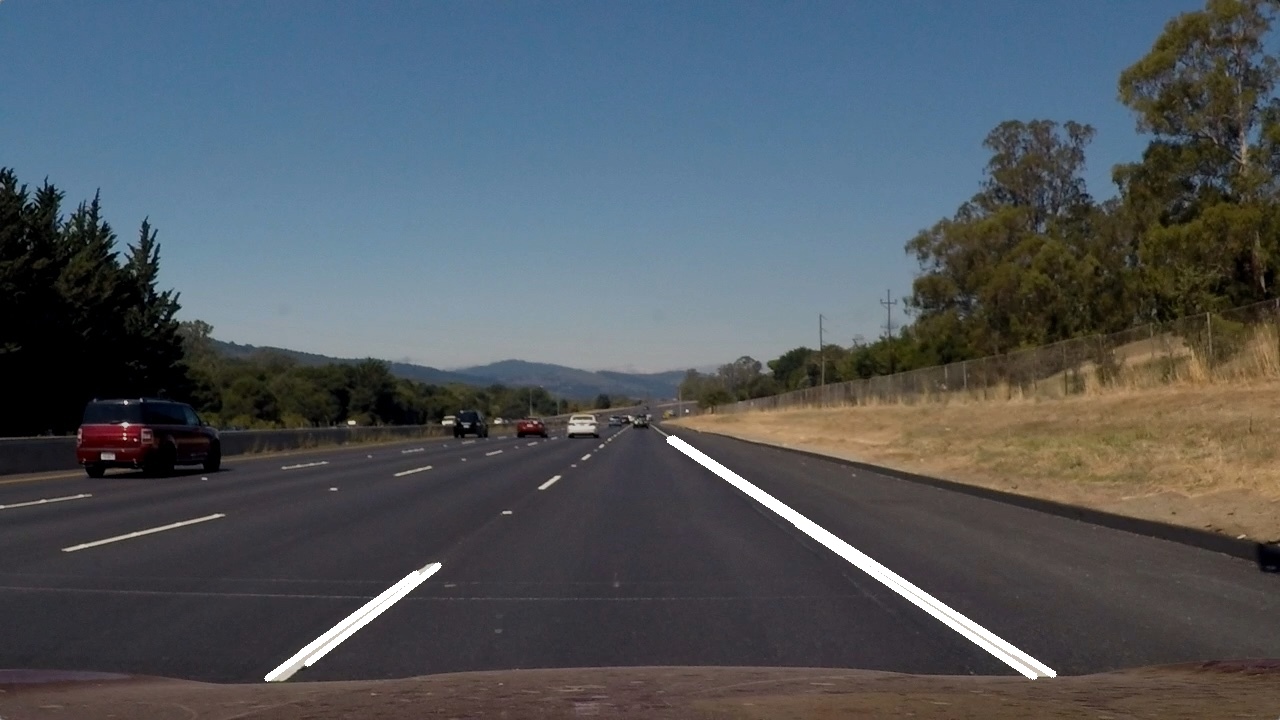



using method 2




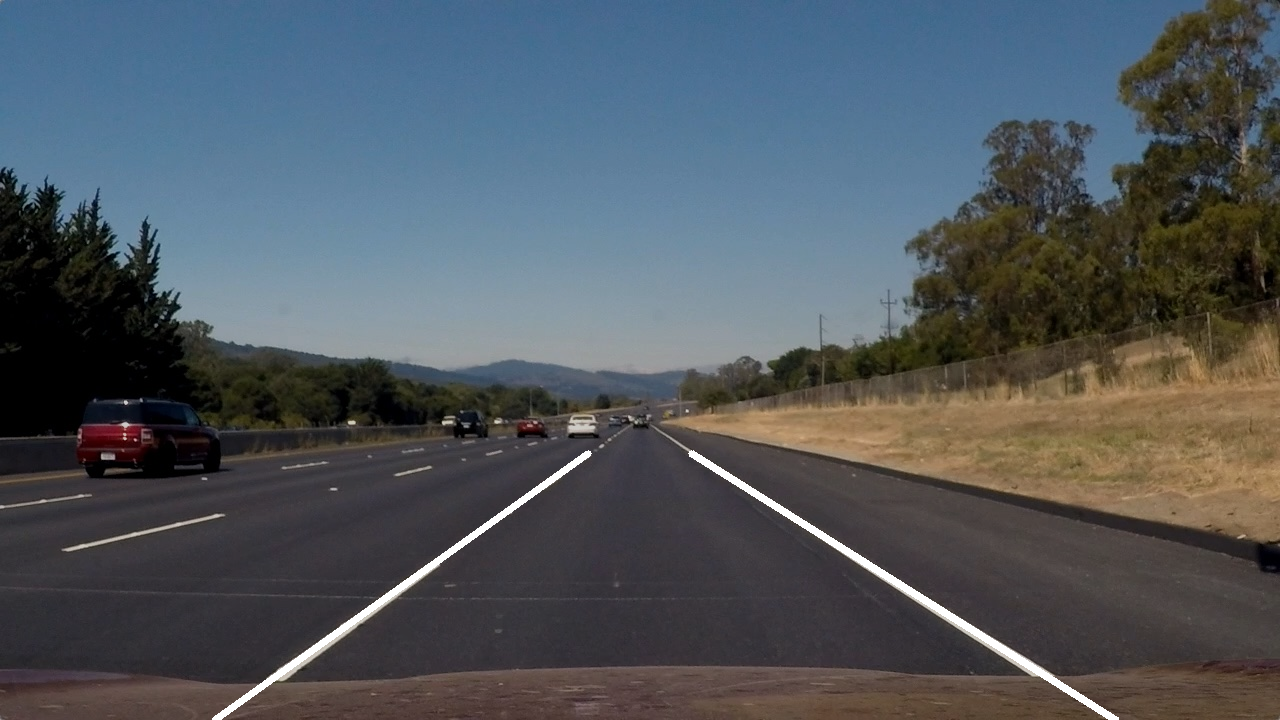

In [ ]:
cv2_imshow(lanes(img3))
print("\n\nusing method 2\n\n")
cv2_imshow(lanes1(img3))